I've decided to use The ResNet50 architecture

# 1. Install all the important libraries and the dataset

In [ ]:
!pip install -q lightning torchsummary datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightning as pl
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from tqdm import tqdm
from torchvision import transforms
from torchsummary import summary
import os
import cv2
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy, F1Score
from pytorch_lightning.loggers import WandbLogger
import torchvision.models as models
import wandb
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:07<00:00, 20.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [ ]:
DATA_PATH = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1'
TRAIN_PATH = DATA_PATH + '/Training'
TEST_PATH = DATA_PATH + '/Testing'

In [ ]:
dataset = {
    "Training": load_dataset("imagefolder", data_dir=TRAIN_PATH),
    "Testing": load_dataset("imagefolder", data_dir=TEST_PATH)
}

Resolving data files:   0%|          | 0/5712 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/1311 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

{'Training': DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 5712
     })
 }),
 'Testing': DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 1311
     })
 })}

# 2. Transform the dataset

## 2.1 Data preparation

We'll use the preprocess steps suggested by the dataset's owner in [this notebook](https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Brain_Tumor_Classification.ipynb)

In [ ]:
class BrainTumorDataset(Dataset):
    def __init__(self, examples, transform = None):
        self.examples = examples
        self.transform = transform
    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]
        image = self._preprocess_image(example["image"])
        image = self.transform(image)
        return image, example["label"]

    def _preprocess_image(self, image):
        image = np.array(image.convert("L"))  # to grayscale
        image = cv2.bilateralFilter(image, 2, 50, 50)  # denoise
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)  # Pseudocolor
        image = cv2.resize(image, (150, 150))  # resize
        image = image.astype(np.float32) / 255.0  # normalize
        return torch.tensor(image).permute(2, 0, 1)  # convert to [C, H, W]

Augment the dataset to avoid overfit

In [ ]:
augmentation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05)
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

Because `random_split` cannot guarantee the classes balance, so we'll use `sklearn`'s `train_test_split` to use the stratify option.

In [ ]:
class BrainTumorDataModule(pl.LightningDataModule):
    def __init__(self, dataset, batch_size=16, transform = None):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.transform = augmentation_transform

    def setup(self, stage=None):
        train_examples = self.dataset["Training"]["train"]
        labels = [ex['label'] for ex in train_examples]

        train_idx, val_idx = train_test_split(
            range(len(train_examples)),
            test_size=0.2,
            stratify=labels,
            random_state=42
        )

        self.train_ds = BrainTumorDataset([train_examples[i] for i in train_idx], self.transform)
        self.val_ds = BrainTumorDataset([train_examples[i] for i in val_idx], self.transform)
        self.test_ds = BrainTumorDataset(self.dataset["Testing"]["train"], self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size)

In [ ]:
data_module = BrainTumorDataModule(dataset)

## 2.2 Split the training data into training and validating set

In [ ]:
data_module.setup()

In [ ]:
train_dataset = data_module.train_dataloader().dataset
val_dataset = data_module.val_dataloader().dataset
test_dataset = data_module.test_dataloader().dataset

# 3. Data exploration

In [ ]:
train_labels = [example["label"] for example in train_dataset.examples]

In [ ]:
train_counts = pd.Series(train_labels).value_counts().reset_index()
train_counts.columns = ["Category", "Count"]

In [ ]:
label_mapping = {
    0: "glioma tumor",
    1: "meningioma tumor",
    2: "no tumor",
    3: "pituitary tumor",
}

train_counts["Category"] = train_counts["Category"].map(label_mapping)

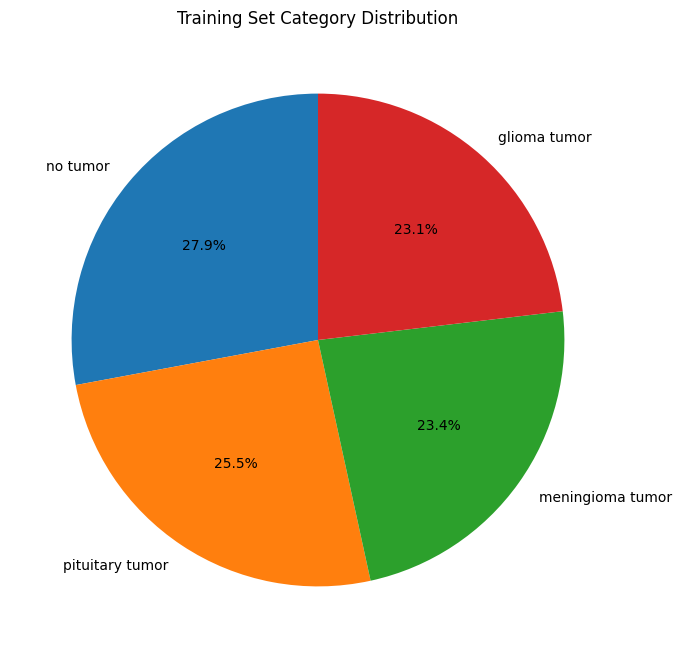

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(train_counts["Count"], labels=train_counts["Category"], autopct="%1.1f%%", startangle=90)
ax.set_title("Training Set Category Distribution")
plt.show()

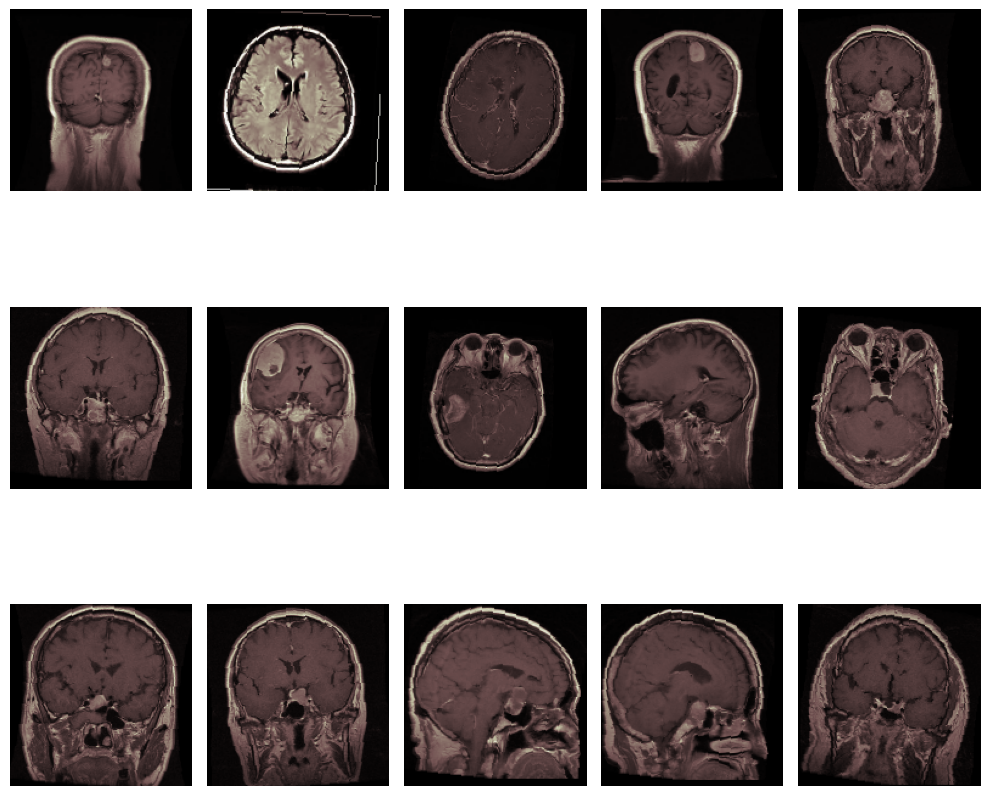

In [ ]:
images = [train_dataset[i][0].permute(1, 2, 0).numpy() for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize=(10, 10))
axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

# 4. Model

We will finetune the ResNet50 model for this task.

Our architecture will have 3 part:

An Encoder : Loads a pretrained ResNet50 model with weights from ImageNet

A Clasification Head: Classify images

A Decoder: To reconstruct the images

## 4.1 The Encoder

We will take all layers of ResNet50 except the last two

In [ ]:
class ResNet50Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])

    def forward(self, x):
        return self.feature_extractor(x)

The dimension:

(3, 150, 150) $\to$ Conv1: (7×7, stride=2, pad=3)  $\to$ (64, 75, 75)

(64, 75, 75) $\to$ MaxPool (3×3, stride=2, pad=1)  $\to$ (64, 38, 38)

(64, 38, 38) $\to$ Layer1 (conv2_x, stride=1) $\to$ (256, 38, 38)

(256, 38, 38) $\to$ Layer2 (conv3_x, stride=2) $\to$  (512, 19, 19)

(512, 19, 19) $\to$ Layer3 (conv4_x, stride=2) $\to$ (1024, 10, 10)

(1024, 10, 10) $\to$ Layer4 (conv5_x, stride=2) $\to$ (2048, 5, 5)

## 4.2 Classification Head:
Imitate the ResNet50's architecture

In [ ]:
class ResNet50ClassificationHead(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), # (2048, 5, 5) -> (2048, 1, 1)
            nn.Flatten(), # (2048, 1, 1) -> (2048,)
            nn.Dropout(0.4),
            nn.Linear(2048, num_classes) # (2048,) -> (4,)
        )

    def forward(self, x):
        return self.classifier(x)

## 4.3 Decoder (Reconstruction Head):

Reconstruct the image by up-sampling (deconvolution)

In [ ]:
class ResNet50ReconstructionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1), # (2048, 5, 5) -> (1024,10,10)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1), # (1024,10,10) -> (512,20,20)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1), # (512,20,20) -> (256,40,40)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # (256,40,40) -> (128,80,80)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # (128,80,80) -> (64,160,160)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),  # (64,160,160) -> (3,160,160)
            nn.Sigmoid()  # Normalize pixels (0-1)
        )

    def forward(self, x):
        features = self.decoder(x)
        return features[:, :, :150, :150] # (3,160,160) -> (3,150,150)

## 4.4 The completed model:

We will use the loss function:

$$
L = L_C + 0.0005 L_R
$$

where L_C is the Classification loss, calculated by Cross Entropy Loss and L_R is the reconstruction loss, calculated by using MSELoss

0.0005 is the constant to keep the effect of L_R small enough (influenced by the original Capsule Network paper)

In [ ]:
class ResNet50Model(pl.LightningModule):
    def __init__(self, num_classes=4, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()

        self.encoder = ResNet50Encoder()
        self.classification_head = ResNet50ClassificationHead(num_classes)
        self.reconstruction_head = ResNet50ReconstructionHead()

        self.classification_loss = nn.CrossEntropyLoss()
        self.reconstruction_loss = nn.MSELoss()

        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.f1_score = F1Score(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        features = self.encoder(x)
        class_output = self.classification_head(features)  # Classification head
        reconstructed_output = self.reconstruction_head(features)  # Reconstruction head
        return class_output, reconstructed_output

    def training_step(self, batch, batch_idx):
        images, labels = batch
        class_preds, reconstructed_preds = self(images)

        class_loss = self.classification_loss(class_preds, labels)
        reconstruction_loss = self.reconstruction_loss(reconstructed_preds, images)

        loss = class_loss + 0.0005*reconstruction_loss
        acc = self.accuracy(class_preds, labels)
        f1 = self.f1_score(class_preds, labels)

        self.log("train_loss", loss, on_epoch=True, on_step=True, prog_bar=True)
        self.log("train_acc", acc, on_epoch=True, on_step=True, prog_bar=True)
        self.log("train_f1", f1, on_epoch=True, on_step=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        class_preds, reconstructed_preds = self(images)

        class_loss = self.classification_loss(class_preds, labels)
        reconstruction_loss = self.reconstruction_loss(reconstructed_preds, images)

        loss = class_loss + 0.0005*reconstruction_loss
        acc = self.accuracy(class_preds, labels)
        f1 = self.f1_score(class_preds, labels)

        self.log("val_loss", loss, on_epoch=True, on_step=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, on_step=True, prog_bar=True)
        self.log("val_f1", f1, on_epoch=True, on_step=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        class_preds, reconstructed_preds = self(images)

        class_loss = self.classification_loss(class_preds, labels)
        reconstruction_loss = self.reconstruction_loss(reconstructed_preds, images)

        loss = class_loss + 0.0005*reconstruction_loss
        acc = self.accuracy(class_preds, labels)
        f1 = self.f1_score(class_preds, labels)

        self.log("test_loss", loss, on_epoch=True, on_step=True, prog_bar=True)
        self.log("test_acc", acc, on_epoch=True, on_step=True, prog_bar=True)
        self.log("test_f1", f1, on_epoch=True, on_step=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.lr)


In [ ]:
model = ResNet50Model()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

summary(model, input_size=(3, 150, 150), device=device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 98.6MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           9,408
       BatchNorm2d-2           [-1, 64, 75, 75]             128
              ReLU-3           [-1, 64, 75, 75]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]           4,096
       BatchNorm2d-6           [-1, 64, 38, 38]             128
              ReLU-7           [-1, 64, 38, 38]               0
            Conv2d-8           [-1, 64, 38, 38]          36,864
       BatchNorm2d-9           [-1, 64, 38, 38]             128
             ReLU-10           [-1, 64, 38, 38]               0
           Conv2d-11          [-1, 256, 38, 38]          16,384
      BatchNorm2d-12          [-1, 256, 38, 38]             512
           Conv2d-13          [-1, 256, 38, 38]          16,384
      BatchNorm2d-14          [-1, 256,

# 5. Training the model

In [ ]:
wandb_logger = WandbLogger(
    project="Brain Tumor", name = "ResNet50",
    )

In [ ]:
trainer = pl.Trainer(
    logger=wandb_logger,
    max_epochs=50,
    accelerator="gpu" if torch.cuda.is_available() else "cpu"
    )
trainer.fit(model, train_dataloaders=data_module.train_dataloader(), val_dataloaders=data_module.val_dataloader())

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sang2222004 (sang2222004-uet-vnu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                | Type                       | Params | Mode 
---------------------------------------------------------------------------
0 | encoder             | ResNet50Encoder            | 23.5 M | train
1 | classification_head | ResNet50ClassificationHead | 8.2 K  | train
2 | reconstruction_head | ResNet50ReconstructionHead | 25.1 M | train
3 | classification_loss | CrossEntropyLoss           | 0      | train
4 | reconstruction_loss | MSELoss                    | 0      | train
5 | accuracy            | MulticlassAccuracy         | 0      | train
6 | f1_score            | MulticlassF1Score          | 0      | train
---------------------------------------------------------------------------
48.7 M    Trainable params
0         Non-trainable params
48.7 M    Total params
194.645   Total estimated model params size (MB)
174       Modules in

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


# 6. Testing phase

In [ ]:
test_loader = data_module.test_dataloader()

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
model = ResNet50Model.load_from_checkpoint(best_model_path)
trainer.test(model, dataloaders=test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.9900839328765869     │
│       test_f1_epoch       │    0.9900839328765869     │
│      test_loss_epoch      │   0.031981710344552994    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.031981710344552994,
  'test_acc_epoch': 0.9900839328765869,
  'test_f1_epoch': 0.9900839328765869}]

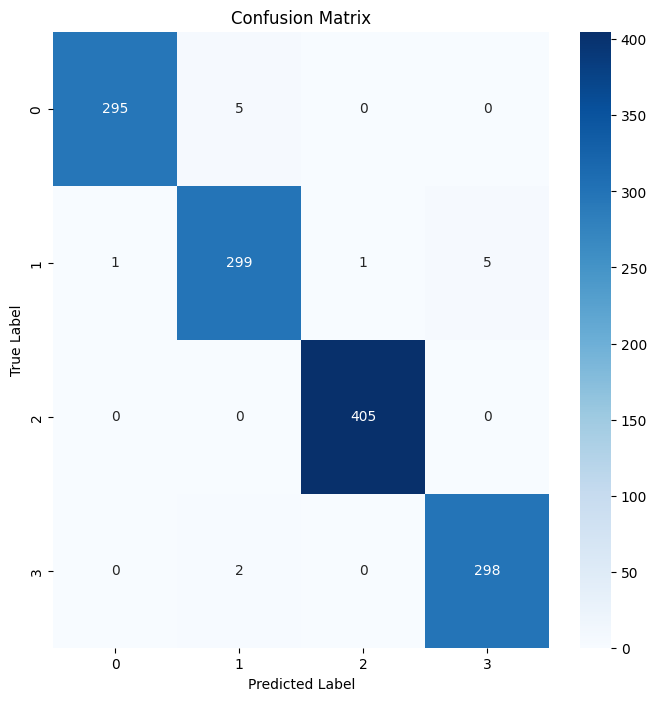

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       300
           1       0.98      0.98      0.98       306
           2       1.00      1.00      1.00       405
           3       0.98      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [ ]:
model.to(device)
model.eval()

all_preds = []
all_labels = []

# inference
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        class_preds, _ = model(images)
        preds = torch.argmax(class_preds, dim=1)


        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

confusionmatrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 8))
sns.heatmap(confusionmatrix, cmap="Blues", annot=True, fmt="d", cbar=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(all_labels, all_preds))

# 7. Reconstruct the image

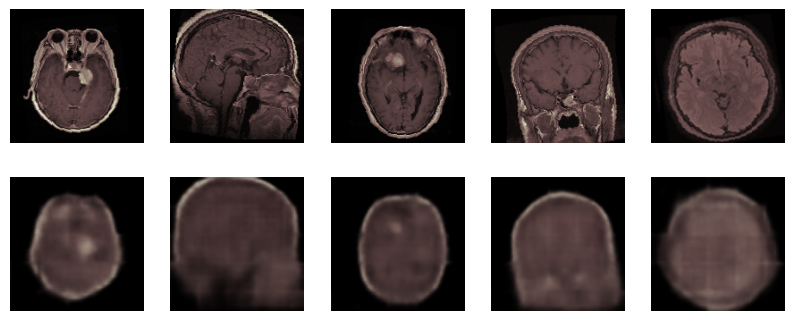

In [ ]:
images, _ = next(iter(data_module.val_dataloader()))  # Get a batch

images = images.to(model.device)

# Generate reconstructed images
model.eval()
with torch.no_grad():
    _, reconstructed_images = model(images)  # Extract reconstructed images

images = images.cpu()
reconstructed_images = reconstructed_images.cpu()

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

num_samples = min(5, images.shape[0])

for i in range(num_samples):
    axes[0, i].imshow(images[i].permute(1, 2, 0))  # Original image
    axes[0, i].axis("off")
    axes[1, i].imshow(reconstructed_images[i].permute(1, 2, 0))  # Reconstructed image
    axes[1, i].axis("off")

plt.show()
